# Split the dataset into train val

In [26]:
import splitfolders # or import splitfolders
input_folder = "/home/kolapally/code/kolapally/computer_vision/data/faces"
output = "/home/kolapally/code/kolapally/computer_vision/data" #where you want the split datasets saved. one will be created if it does not exist or none is set

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .2)) # ratio of split are in order of train/val/test. You can change to whatever you want. For train/val sets only, you could do .75, .25 for example.

Copying files: 171 files [00:00, 6674.29 files/s]


# data augmentation

In [27]:
import os
import pandas as pd
import shutil
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def make_dataframe(sdir):
    # sdir is the directory when the class subdirectories are stored
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    # return a dataframe with columns filepaths, labels
    return df

def make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg'):
    #augdir is the full path where augmented images will be stored
    #n is the number of augmented images that will be created for each class that has less than n image samples
    # img_size  is a tupple(height,width) that specifies the size of the augmented images
    # color_mode is 'rgb by default'
    # save_prefix is the prefix augmented images are identified with by default it is 'aug-'
    #save_format is the format augmented images will be save in, by default it is 'jpg'
    # see documentation of ImageDataGenerator at https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator for details
    df=df.copy()        
    if os.path.isdir(augdir):# start with an empty directory
        shutil.rmtree(augdir)
    os.mkdir(augdir)  # if directory does not exist create it      
    for label in df['labels'].unique():    
        classpath=os.path.join(augdir,label)    
        os.mkdir(classpath) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    # in ImageDateGenerator select the types of augmentation you desire  below are some examples  
    gen=ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               shear_range=0.01,
                               zoom_range=[0.9, 1.25],
                               horizontal_flip=True,
                               vertical_flip=False,
                               fill_mode='reflect',
                               data_format='channels_last',
                               brightness_range=[0.5, 1.5])
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class
        classdir=os.path.join(augdir, label)
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class  
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create            
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=classdir, save_prefix=save_prefix, color_mode=color_mode,
                                            save_format=save_format)
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count        
    print('Total Augmented images created= ', total)

In [51]:
sdir=r'/home/kolapally/code/kolapally/computer_vision/data/train'
df=make_dataframe(sdir)
print (df.head())
print ('length of dataframe is ',len(df))

augdir=r'/home/kolapally/code/kolapally/computer_vision/data/Aug' # directory to store the images if it does not exist it will be created
n=1000# if the class had N image samples in the sdir, if N<n than in augdir n-N augmented images will be created 
img_size=(128,128) # image size (height,width) of augmented images
make_and_store_images(df, augdir, n,  img_size,  color_mode='rgb', save_prefix='aug-',save_format='jpg')

Pam                      : 100%|████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 54295.20files/s]

                                           filepaths  labels
0  /home/kolapally/code/kolapally/computer_vision...  Angela
1  /home/kolapally/code/kolapally/computer_vision...  Angela
2  /home/kolapally/code/kolapally/computer_vision...  Angela
3  /home/kolapally/code/kolapally/computer_vision...  Angela
4  /home/kolapally/code/kolapally/computer_vision...  Angela
length of dataframe is  135
Found 21 validated image filenames.      for class             Angela             creating  979  augmented images 


Found 21 validated image filenames.      for class             Dwight             creating  979  augmented images 
Found 24 validated image filenames.      for class              Jim               creating  976  augmented images 
Found 23 validated image filenames.      for class             Kevin              creating  977  augmented images 
Found 22 validated image filenames.      for class            Michael             creating  978  augmented images 
Found 24 validated image filenames.      for class              Pam               creating  976  augmented images 
Total Augmented images created=  5865


# imagedataset from dictionary

In [29]:
from  tensorflow.keras.utils import image_dataset_from_directory

In [52]:
images_train = image_dataset_from_directory(
                                             directory = '/home/kolapally/code/kolapally/computer_vision/data/Aug',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam'],
                                                    image_size = (128,128),
                                                    seed = 42,
                                                    validation_split = 0.01,
                                                      subset = 'training',
                                                   interpolation = 'area',
                                                     crop_to_aspect_ratio = True)

Found 5865 files belonging to 6 classes.
Using 5807 files for training.


In [53]:
images_val = image_dataset_from_directory(
                                             directory = '/home/kolapally/code/kolapally/computer_vision/data/val/',
                                                    batch_size=32,
                                                   labels = 'inferred',
                                                   label_mode='categorical',
#       class_names=['Angela','Dwight','Jim','Kevin','Michael','Pam'],
                                                    image_size = (128,128),
                                                    seed = 42,
                                                    validation_split = 0.99,
                                                      subset = 'validation',
                                                   interpolation = 'area',
                                                     crop_to_aspect_ratio = True)

Found 36 files belonging to 6 classes.
Using 35 files for validation.


In [54]:
class_names = images_train.class_names

In [34]:
import matplotlib.pyplot as plt
import numpy as np 

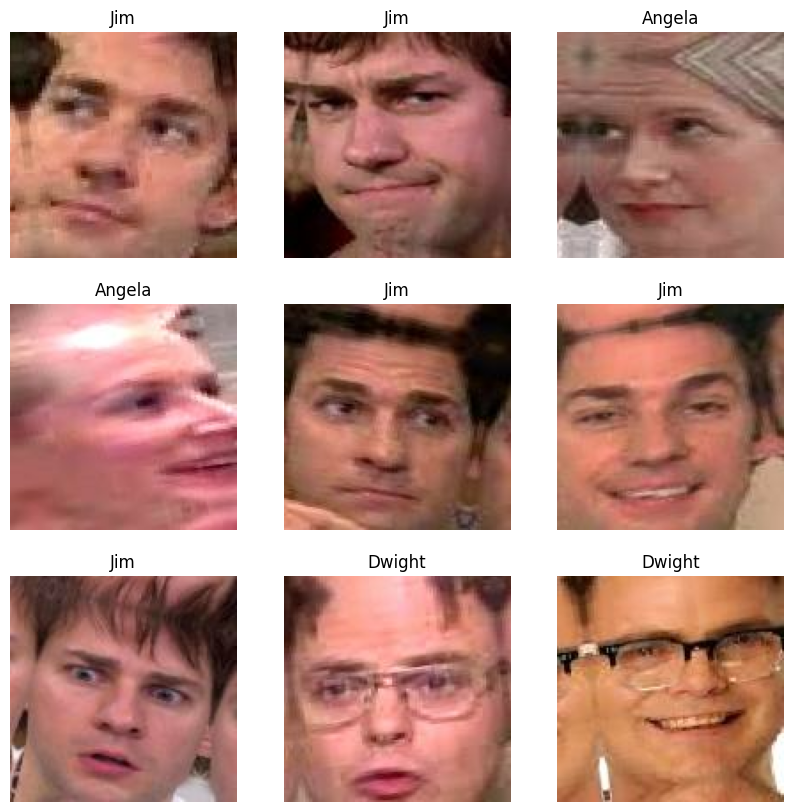

In [55]:
plt.figure(figsize=(10, 10))
for images, labels in images_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


# model with resnet150

In [40]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet152

In [56]:
base_model = ResNet152(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the pre-trained VGG16 model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.15),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

In [57]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 4, 4, 2048)        58370944  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 75,281,542
Trainable params: 16,910,598


In [43]:
from tensorflow.keras.optimizers import Adam

In [58]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(learning_rate=0.02),
              metrics = ['accuracy']
             )

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_accuracy',patience = 5,restore_best_weights=True)

In [62]:
history = model.fit(images_train,
                  epochs = 100,batch_size=32,
               verbose=1, validation_data=images_val,
               callbacks = [es]
              )

Epoch 1/100
